In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/blogtext.csv")
data = data[:100]
data.head()

id gender  age              topic      sign          date  \
0  2059027   male   15            Student       Leo   14,May,2004   
1  2059027   male   15            Student       Leo   13,May,2004   
2  2059027   male   15            Student       Leo   12,May,2004   
3  2059027   male   15            Student       Leo   12,May,2004   
4  3581210   male   33  InvestmentBanking  Aquarius  11,June,2004   

                                                text  
0             Info has been found (+/- 100 pages,...  
1             These are the team members:   Drewe...  
2             In het kader van kernfusie op aarde...  
3                   testing!!!  testing!!!            
4               Thanks to Yahoo!'s Toolbar I can ...

# Model typu encoder (BertForSequenceClassification)

In [3]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, problem_type="multi_label_classification", num_labels=4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

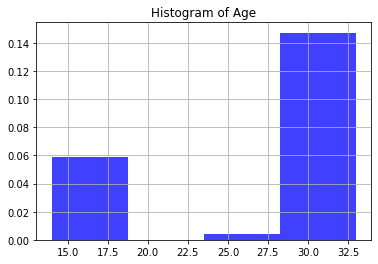

<Figure size 10000x10000 with 0 Axes>

In [55]:
n, bins, patches = plt.hist(data['age'], 4, density=True, facecolor='b', alpha=0.75)

plt.title('Histogram of Age')
plt.grid(True)
plt.figure(figsize=(100,100), dpi=100)
plt.show()

In [11]:
"""
1 - 22 -> 1 klasa
23 - 31 -> 2 klasa
32 - 39 -> 3 klasa 
40 - 48 -> 4 klasa
"""

def mapAgeToClass(value: pd.DataFrame) -> int:
    if(value['age'] <=22):
        return 1
    elif(value['age'] > 22 and value['age'] <= 31):
        return 2
    elif(value['age'] > 31 and value['age'] <= 39):
        return 3
    else:
        return 4

def mapAgeToClass2(value: pd.DataFrame) -> int:
    if(value['age'] <=22):
        return [1.0,0.0,0.0,0.0]
    elif(value['age'] > 22 and value['age'] <= 31):
        return [0.0,1.0,0.0,0.0]
    elif(value['age'] > 31 and value['age'] <= 39):
        return [0.0,0.0,1.0,0.0]
    else:
        return [0.0,0.0,0.0,1.0]
    
data['label'] = data.apply(lambda row: mapAgeToClass2(row), axis=1)
data.head()



id gender  age              topic      sign          date  \
0  2059027   male   15            Student       Leo   14,May,2004   
1  2059027   male   15            Student       Leo   13,May,2004   
2  2059027   male   15            Student       Leo   12,May,2004   
3  2059027   male   15            Student       Leo   12,May,2004   
4  3581210   male   33  InvestmentBanking  Aquarius  11,June,2004   

                                                text                 label  
0             Info has been found (+/- 100 pages,...  [1.0, 0.0, 0.0, 0.0]  
1             These are the team members:   Drewe...  [1.0, 0.0, 0.0, 0.0]  
2             In het kader van kernfusie op aarde...  [1.0, 0.0, 0.0, 0.0]  
3                   testing!!!  testing!!!            [1.0, 0.0, 0.0, 0.0]  
4               Thanks to Yahoo!'s Toolbar I can ...  [0.0, 0.0, 1.0, 0.0]

In [12]:
X = list(data['text'])
Y = list(data['label'])
if (torch.cuda.is_available()):
    device = "cuda:0"
    torch.cuda.empty_cache()
else:
    device = "cpu"
device = "cpu"

# model = model.to(device)

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
# .to(device)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
# .to(device)


In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [13]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [8]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [14]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    no_cuda=True
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [15]:
trainer.train()

/home/ramon/projects/projekt_glebokie/venv/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 80
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


In [ ]:
raw_pred, _, _ = trainer.predict(val_dataset)

In [ ]:
y_pred = np.argmax(raw_pred, axis=1)

# Model typu decoder